### **Cell 1: Imports and global setup**

In [71]:
import json
import random
import re
from pathlib import Path

import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

# --- Path and Directory Definitions ---

def find_project_root(marker: str = ".git") -> Path:
    """Traverse upwards to find the project root, marked by the git repository."""
    current_path = Path.cwd().resolve()
    while current_path != current_path.parent:
        if (current_path / marker).exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError(f"Could not find project root. Marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = DATA_DIR / "sft-datasets/level-1-binary"

# --- Ensure output directory exists ---
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Dataset output directory: {OUTPUT_DIR}")

Project root: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math
Dataset output directory: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/sft-datasets/level-1-binary


### **Cell 2: Load raw data sources**

In [72]:
# --- Load Catalog of Programmatically generated Computational Errors ---
PROGRAMMATIC_COMPUTATIONAL_ERRORS_DIR = DATA_DIR / "computational-errors-generated"
PROGRAMMATIC_CATALOG_PATH = PROGRAMMATIC_COMPUTATIONAL_ERRORS_DIR / "computational_error_catalog.csv"
programmatic_catalog_df = pd.read_csv(PROGRAMMATIC_CATALOG_PATH)

# --- Load csv of Manually generated errors ---
MANUAL_ERRORS_CSV_PATH = DATA_DIR / "manually_generated_errors_final.csv"
manual_errors_df = pd.read_csv(MANUAL_ERRORS_CSV_PATH)

# --- Load Original GSM8K Dataset for 'Correct' examples ---
GSM8K_TRAIN_DATASET: Dataset = load_dataset("gsm8k", "main")["train"]

print(f"Loaded {len(programmatic_catalog_df)} records from programmatic error catalog.")
print(f"Loaded {len(manual_errors_df)} records from manual error CSV.")
print(f"Loaded {len(GSM8K_TRAIN_DATASET)} samples from gsm8k/main train split.")

Loaded 16506 records from programmatic error catalog.
Loaded 1963 records from manual error CSV.
Loaded 7473 samples from gsm8k/main train split.


### **Cell 3: Define core data pipeline functions**

In [ ]:
def sanitize_commas(text: str) -> str:
    """Removes comma separators from numbers to prevent model artifacts."""
    return re.sub(r'(\d),(\d)', r'\1\2', text)

def prepare_manual_samples(
    df: pd.DataFrame,
    error_type_filter: str,
    exclude_indices: set[int] = set(),
    seed: int = 42
) -> tuple[list[dict], list[dict], set[int]]:
    """
    Prepares paired correct/flawed samples from the manual errors DataFrame,
    ensuring each unique problem index is used only once. If an index has
    multiple manual errors of the same type, one is chosen randomly.
    """
    samples, metadata = [], []
    rng = random.Random(seed)

    subset_df = df[
        (df['error_type'] == error_type_filter) &
        (~df['index'].isin(exclude_indices))
    ].copy()
    
    unique_indices_to_process = sorted(list(set(subset_df['index'])))
    
    for idx in unique_indices_to_process:
        candidate_rows = subset_df[subset_df['index'] == idx]
        
        # --- FIX: Use an integer for the random_state seed ---
        chosen_row = candidate_rows.sample(n=1, random_state=rng.randint(0, 10**9)).iloc[0]

        samples.append({"index": idx, "question": chosen_row['question'], "solution": sanitize_commas(chosen_row['answer']), "label": 0})
        metadata.append({"index": idx, "label": 0, "error_type": "correct", "source_file": "gsm8k.main.train"})
        
        samples.append({"index": idx, "question": chosen_row['question'], "solution": sanitize_commas(chosen_row['wrong_answer']), "label": 1})
        metadata.append({"index": idx, "label": 1, "error_type": chosen_row['error_type'], "source_file": chosen_row['filepath']})
        
    return samples, metadata, set(unique_indices_to_process)

def prepare_programmatic_samples(
    catalog_df: pd.DataFrame, gsm8k_lookup: dict,
    exclude_indices: set[int], project_root: Path, seed: int = 42,
    max_samples: int = 500
) -> tuple[list[dict], list[dict]]:
    """
    Prepares n paired correct/flawed samples from the programmatic error catalog,
    first pre-validating all files to ensure data integrity.
    """
    print("Pre-validating programmatic error files...")
    valid_programmatic_sources = []
    programmatic_indices_seen = set()
    
    for _, row in catalog_df.iterrows():
        idx = row['index']
        if idx in exclude_indices or idx in programmatic_indices_seen:
            continue
        
        filepath_val = row.get('filepath')
        if pd.isna(filepath_val):
            continue
            
        try:
            filepath = project_root / str(filepath_val)
            with open(filepath, 'r') as f:
                if "flawed_nl_solution" in json.load(f):
                    valid_programmatic_sources.append({'index': idx, 'filepath': filepath_val})
                    programmatic_indices_seen.add(idx)
        except (FileNotFoundError, json.JSONDecodeError):
            continue
    
    print(f"Found {len(valid_programmatic_sources)} unique, valid, and unused programmatic problems.")
    
    samples, metadata = [], []
    rng = random.Random(seed)
    num_to_sample = min(max_samples, len(valid_programmatic_sources))
    chosen_sources = rng.sample(valid_programmatic_sources, k=num_to_sample)

    for source in chosen_sources:
        idx, filepath_val = source['index'], source['filepath']
        try:
            filepath = project_root / str(filepath_val)
            with open(filepath, 'r') as f:
                flawed_solution = json.load(f)["flawed_nl_solution"]
        except Exception:
            continue
        
        original_problem = gsm8k_lookup[idx]
        samples.append({"index": idx, "question": original_problem['question'], "solution": sanitize_commas(original_problem['answer']), "label": 0})
        metadata.append({"index": idx, "label": 0, "error_type": "correct", "source_file": "gsm8k.main.train"})
        
        samples.append({"index": idx, "question": original_problem['question'], "solution": sanitize_commas(flawed_solution), "label": 1})
        metadata.append({"index": idx, "label": 1, "error_type": "computational", "source_file": filepath_val})
        
    return samples, metadata

def split_dataset_by_index(dataset_list: list[dict], train_size: float = 0.8, seed: int = 42) -> DatasetDict:
    """
    Splits a list of samples into train, validation, and test sets based on
    the problem 'index' to prevent data leakage between splits.

    Args:
        dataset_list: The list of all data samples.
        train_size: The proportion of unique indices for the training set.
        seed: A random seed for a reproducible split.

    Returns:
        A Hugging Face DatasetDict with 'train', 'validation', and 'test' splits.
    """
    all_indices = sorted(list(set(item['index'] for item in dataset_list)))
    random.Random(seed).shuffle(all_indices)
    
    train_end = int(len(all_indices) * train_size)
    val_end = train_end + int((len(all_indices) - train_end) / 2)
    
    train_indices = set(all_indices[:train_end])
    val_indices = set(all_indices[train_end:val_end])
    test_indices = set(all_indices[val_end:])
    
    train_data = [item for item in dataset_list if item['index'] in train_indices]
    val_data = [item for item in dataset_list if item['index'] in val_indices]
    test_data = [item for item in dataset_list if item['index'] in test_indices]
    
    return DatasetDict({
        "train": Dataset.from_list(train_data),
        "validation": Dataset.from_list(val_data),
        "test": Dataset.from_list(test_data)
    })

### **Cell 4: Execute Full Pipeline (Merge-Then-Split)**

In [74]:
print("--- Starting Hierarchical Data Preparation Pipeline ---")

# 1. Build a lookup for original GSM8K problems
gsm8k_lookup = {
    i: {"question": q, "answer": a}
    for i, (q, a) in enumerate(zip(GSM8K_TRAIN_DATASET["question"], GSM8K_TRAIN_DATASET["answer"]))
}

# 2. Prepare each data subset hierarchically
print("Step 1: Preparing manual conceptual pairs...")
conceptual_samples, conceptual_meta, used_indices_conceptual = prepare_manual_samples(
    manual_errors_df, "conceptual"
)
num_conceptual = len(used_indices_conceptual)
print(f"-> Generated {len(conceptual_samples)} samples from {num_conceptual} unique conceptual problems.")

print("\nStep 2: Preparing manual computational pairs...")
computational_samples, computational_meta, used_indices_computational = prepare_manual_samples(
    manual_errors_df, "computational", exclude_indices=used_indices_conceptual
)
num_manual_computational = len(used_indices_computational)
print(f"-> Generated {len(computational_samples)} samples from {num_manual_computational} unique computational problems.")

# --- START MODIFICATION: DYNAMIC BALANCING LOGIC ---
# Calculate how many programmatic samples are needed to balance the classes.
num_programmatic_needed = num_conceptual - num_manual_computational
# Ensure we don't request a negative number of samples if computational > conceptual.
num_programmatic_to_generate = max(0, num_programmatic_needed)

print(f"\nStep 3: Preparing programmatic computational pairs to balance dataset...")
print(f"Conceptual count: {num_conceptual}, Manual Computational count: {num_manual_computational}.")
print(f"--> Targeting {num_programmatic_to_generate} programmatic samples to achieve balance.")

all_manual_indices = used_indices_conceptual.union(used_indices_computational)
programmatic_samples, programmatic_meta = prepare_programmatic_samples(
    catalog_df=programmatic_catalog_df,
    gsm8k_lookup=gsm8k_lookup,
    exclude_indices=all_manual_indices,
    project_root=PROJECT_ROOT,
    max_samples=num_programmatic_to_generate  # Use the dynamically calculated number
)
print(f"-> Actually generated {len(programmatic_samples)} samples from {len(programmatic_samples)//2} unique programmatic problems.")
# --- END MODIFICATION ---

# 4. Merge all samples and metadata into single lists
final_dataset_list = conceptual_samples + computational_samples + programmatic_samples
final_metadata_list = conceptual_meta + computational_meta + programmatic_meta
total_conceptual = len(conceptual_samples) // 2
total_computational = (len(computational_samples) // 2) + (len(programmatic_samples) // 2)
print(f"\nTotal samples in final combined dataset: {len(final_dataset_list)}")
print(f"Final error distribution: {total_conceptual} Conceptual vs. {total_computational} Computational.")

# 5. Save the combined metadata catalog
metadata_df = pd.DataFrame(final_metadata_list)
CATALOG_PATH = OUTPUT_DIR / "sft_level1_catalog.csv"
metadata_df.to_csv(CATALOG_PATH, index=False)
print(f"-> Metadata catalog with {len(metadata_df)} records saved to: {CATALOG_PATH}")

# 6. Shuffle, split, and save the final dataset
random.Random(42).shuffle(final_dataset_list)
print("\nSplitting final dataset and saving to disk...")
sft_dataset = split_dataset_by_index(final_dataset_list, train_size=0.8)
sft_dataset.save_to_disk(OUTPUT_DIR)
print(f"-> Dataset splits successfully saved to: {OUTPUT_DIR}")

print("\n--- Final Dataset Structure ---")
print(sft_dataset)
print("\n--- Pipeline Complete ---")

--- Starting Hierarchical Data Preparation Pipeline ---
Step 1: Preparing manual conceptual pairs...
-> Generated 2060 samples from 1030 unique conceptual problems.

Step 2: Preparing manual computational pairs...
-> Generated 840 samples from 420 unique computational problems.

Step 3: Preparing programmatic computational pairs to balance dataset...
Conceptual count: 1030, Manual Computational count: 420.
--> Targeting 610 programmatic samples to achieve balance.
Pre-validating programmatic error files...
Found 1394 unique, valid, and unused programmatic problems.
-> Actually generated 1220 samples from 610 unique programmatic problems.

Total samples in final combined dataset: 4120
Final error distribution: 1030 Conceptual vs. 1030 Computational.
-> Metadata catalog with 4120 records saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/sft-datasets/level-1-binary/sft_level1_catalog.csv

Splitting final dataset and saving to disk...


Saving the dataset (0/1 shards):   0%|          | 0/3296 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/412 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/412 [00:00<?, ? examples/s]

-> Dataset splits successfully saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/sft-datasets/level-1-binary

--- Final Dataset Structure ---
DatasetDict({
    train: Dataset({
        features: ['index', 'question', 'solution', 'label'],
        num_rows: 3296
    })
    validation: Dataset({
        features: ['index', 'question', 'solution', 'label'],
        num_rows: 412
    })
    test: Dataset({
        features: ['index', 'question', 'solution', 'label'],
        num_rows: 412
    })
})

--- Pipeline Complete ---


### **Cell 7: Verification - inspect random samples**

In [75]:
def display_paired_samples(dataset_list: list[dict], n: int = 3):
    """
    Selects n random problem indices and displays the corresponding correct/flawed
    pair of samples from the provided list for verification.

    Args:
        dataset_list: The full list of data points before splitting.
        n: The number of random pairs to display.
    """
    if not isinstance(dataset_list, list) or not dataset_list:
        print("Error: Please provide a non-empty list of data samples.")
        return

    unique_indices = sorted(list(set(item['index'] for item in dataset_list)))
    if not unique_indices:
        print("Dataset contains no valid indices.")
        return
        
    num_unique_problems = len(unique_indices)
    n = min(n, num_unique_problems)
    random_indices = random.sample(unique_indices, k=n)
    
    print(f"--- Displaying {n} random correct/flawed pairs for inspection ---")
    
    for i, problem_index in enumerate(random_indices):
        print(f"\n{'='*25} Pair {i + 1}/{n} (Problem Index: {problem_index}) {'='*25}")
        pair = [item for item in dataset_list if item.get('index') == problem_index]
        pair.sort(key=lambda x: x['label'])
        
        print("\n--- Correct (Label 0) ---")
        print(json.dumps(pair[0], indent=2, ensure_ascii=False))
        
        print("\n--- Flawed (Label 1) ---")
        print(json.dumps(pair[1], indent=2, ensure_ascii=False))

    print("\n" + "=" * 70)

In [76]:
# --- Inspect 2 random pairs from the generated dataset ---
display_paired_samples(final_dataset_list, n=5)

--- Displaying 5 random correct/flawed pairs for inspection ---

========================= Pair 1/5 (Problem Index: 1052) =========================

--- Correct (Label 0) ---
{
  "index": 1052,
  "question": "James turned 23 the same time John turned 35.  Tim is 5 years less than twice John's age.  If Tim is 79 how old is James?",
  "solution": "James is 35-23=<<35-23=12>>12 years younger than John\n5 years less than Tim's age is 79-5=74 years old\nSo John is 74/2=<<74/2=37>>37 years old\nThat means James is 37-12=<<37-12=25>>25 years old\n#### 25",
  "label": 0
}

--- Flawed (Label 1) ---
{
  "index": 1052,
  "question": "James turned 23 the same time John turned 35.  Tim is 5 years less than twice John's age.  If Tim is 79 how old is James?",
  "solution": "James is 35-23=<<35-23=12>>12 years younger than John\n5 years less than Tim's age is 79-5=74 years old\nSo John is 74/2=<<74/2=37>>37 years old\nThat means James is 37+12=<<37+12=49>>49 years old\n#### 49",
  "label": 1
}

======

Binary confusion-matrix (0=correct, 1=flawed):
 [[198   8]
 [ 31 175]]


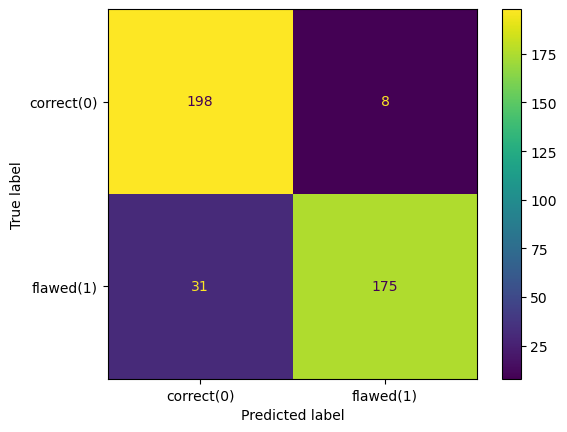

3 × 2 confusion matrix:
pred           correct  flawed
true                          
correct            198       8
conceptual          21      89
computational       10      86


In [83]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

PHI4_PREDICTED_PROBAS_PATH = OUTPUT_DIR / "phi4-mini-level-1-test-preds.csv"

# ── 1 · load files ───────────────────────────────────────────────
probs_df  = pd.read_csv(PHI4_PREDICTED_PROBAS_PATH)                 # your earlier export
meta_df   = pd.read_csv(CATALOG_PATH)  # the metadata file

# ── 2 · merge on (index, true_label) ─────────────────────────────

# Rename label to true_label for consistency
meta_df.rename(columns={"label": "true_label"}, inplace=True)
df = probs_df.merge(meta_df, on=["index", "true_label"], how="inner")

# sanity-check
assert len(df) == len(probs_df), "some rows failed to merge"

# ── 3 · binary confusion matrix (correct = 0, incorrect = 1) ─────
# 3.1 predicted class from probs
prob_cols = [c for c in df.columns if c.startswith("p(class=")]
df["y_pred"]  = df[prob_cols].values.argmax(axis=1)            # 0 or 1
df["y_true"]  = df["true_label"]                               # 0 or 1

cm_bin = confusion_matrix(df["y_true"], df["y_pred"], labels=[0, 1])
print("Binary confusion-matrix (0=correct, 1=flawed):\n", cm_bin)

# (optional) visual
ConfusionMatrixDisplay(cm_bin, display_labels=["correct(0)", "flawed(1)"]).plot()
plt.show()

# ── 4 · 3-class confusion matrix ────────────────────────────────
# ── map ground-truth into three groups ───────────────────────────────────────
def collapse_error_type(row):
    if row["true_label"] == 0:
        return "correct"
    return "conceptual" if row["error_type"] == "conceptual" else "computational"

df["y_true_3"] = df.apply(collapse_error_type, axis=1)

# ── binary model output: 0 → correct, 1 → **generic “incorrect”** ────────────
df["y_pred_2"] = df["y_pred"].map({0: "correct", 1: "flawed"})

# ── 3 × 2 confusion matrix via crosstab ───────────────────────────
cm_3x2 = pd.crosstab(
    df["y_true_3"],
    df["y_pred_2"],
    rownames=["true"],
    colnames=["pred"],
    dropna=False,
).reindex(index=["correct", "conceptual", "computational"],
          columns=["correct", "flawed"],
          fill_value=0)

print("3 × 2 confusion matrix:")
print(cm_3x2)

In [84]:
# df already contains:
#   • y_true  – 0 (correct) / 1 (incorrect)
#   • y_pred  – model’s 0/1 prediction
#   • error_type – "correct", "conceptual", "computational", or subtype

# masks for the two subsets (always belong to y_true == 1)
conceptual_mask     = df["error_type"] == "conceptual"
computational_mask  = (df["y_true"] == 1) & ~conceptual_mask   # all other error types

# accuracy = fraction of rows where prediction == truth
acc_conceptual    = (df.loc[conceptual_mask,   "y_pred"] == df.loc[conceptual_mask,   "y_true"]).mean()
acc_computational = (df.loc[computational_mask,"y_pred"] == df.loc[computational_mask,"y_true"]).mean()

print(f"Conceptual errors   — accuracy: {acc_conceptual:.4f}  (n={conceptual_mask.sum()})")
print(f"Computational errors — accuracy: {acc_computational:.4f}  (n={computational_mask.sum()})")

Conceptual errors   — accuracy: 0.8091  (n=110)
Computational errors — accuracy: 0.8958  (n=96)
